In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

project_directory = "drive/My Drive/Colab Notebooks/Final Project/"


Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from zipfile import ZipFile
zip_project = project_directory + "XN_Project.zip"
with ZipFile(zip_project, 'r') as zip:
  zip.extractall()
  print('Done')
 #REFRESH PAGE

NotImplementedError: ignored

In [ ]:
types = ["epidural", "intraparenchymal", 
         "intraventricular", "subarachnoid", 
         "subdural", "normal", "multi"]
         
zip_project =  "XN_Project/renders/"

for t in types:

  with ZipFile(zip_project + t + ".zip", 'r') as zip:
    zip.extractall()
    print(t, 'Done')

In [ ]:
def type_update (row):
   if row['any'] == 0 :
      return 'normal'
   if row['epidural'] + row['intraparenchymal'] + row['intraventricular'] + row['subarachnoid'] + row['subdural'] > 1 :
      return 'multi'
   if row['epidural'] == 1 :
      return 'epidural'
   if row['intraparenchymal'] == 1:
      return 'intraparenchymal'
   if row['intraventricular']  == 1:
      return 'intraventricular'
   if row['subarachnoid'] == 1:
      return 'subarachnoid'
   if row['subdural'] == 1:
      return 'subdural'
   return 'normal'

def category_update (row):
   if row['any'] == 0 :
      return 0
   if row['epidural'] + row['intraparenchymal'] + row['intraventricular'] + row['subarachnoid'] + row['subdural'] > 1 :
      return 6
   if row['epidural'] == 1 :
      return 1
   if row['intraparenchymal'] == 1:
      return 2
   if row['intraventricular']  == 1:
      return 3
   if row['subarachnoid'] == 1:
      return 4
   if row['subdural'] == 1:
      return 5
   return 0

In [ ]:
labels = pd.read_csv("XN_Project/hemorrhage-labels.csv")
labels["type"] = labels.apply(type_update, axis = 1)
labels["category"] = labels.apply(category_update, axis = 1)
with open(project_directory + 'Hemorrhage Segmentation Project/flagged.txt') as f:
    for line in f.readlines():
      labels = labels[labels["Image"] != line[:-5]]

display(labels)

In [ ]:
#Get only the labels that have a max_contrast_window picture associated with it
import os
max_contrast_files = []
for t in types:
  path = t + "/max_contrast_window"
  curr_list = os.listdir(path)
  for i in range(len(curr_list)):
    max_contrast_files.append(curr_list[i][:-4])
  
max_contrast_df = labels[labels["Image"].isin(max_contrast_files)]

for i in range(7):
  print(i, len(max_contrast_df[max_contrast_df["category"]== i]))

In [ ]:
def random_choice(n, hem_type, df):
  df = df[df["category"] == hem_type]
  df = df.sample(n=n)
  return df


In [ ]:
random_df = random_choice(250,0, max_contrast_df)
for i in range (1, 7):
  curr_df = random_choice(250, i, max_contrast_df)
  random_df = random_df.append(curr_df, ignore_index=True)

im_id = random_df["Image"].tolist()

drop_im = []
for i in range(len(im_id)):
  hem_type = str(random_df.iloc[i]["type"])
  path = hem_type + "/max_contrast_window/" + id + ".jpg"
  if np.mean(mpl.image.imread(path),axis=2).size != 262144:
    im_id.pop(i)





In [ ]:


non_id = []
for i in range(len(random_df)):
  id = random_df.iloc[i]["Image"]
  hem_type = (random_df.iloc[i]["type"])
  path = hem_type + "/max_contrast_window/" + id + ".jpg"
  if np.mean(mpl.image.imread(path),axis=2).size != 262144:
    non_id.append(id)


In [ ]:
random_df = random_df[~random_df["Image"].isin(non_id)]

random_df

,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,type,category
0,ID_012a93229,0,0,0,0,0,0,normal,0
1,ID_0005b2d86,0,0,0,0,0,0,normal,0
2,ID_02bb16767,0,0,0,0,0,0,normal,0
3,ID_024f328dd,0,0,0,0,0,0,normal,0
4,ID_026cd4842,0,0,0,0,0,0,normal,0
...,...,...,...,...,...,...,...,...,...
1745,ID_b9723325a,1,0,1,1,1,1,multi,6
1746,ID_60ff6ffb1,1,1,1,1,0,1,multi,6
1747,ID_951ef40f7,1,0,0,0,1,1,multi,6
1748,ID_a35d5441a,1,0,0,1,1,0,multi,6


In [ ]:
from collections.abc import Sized
from tensorflow.python import image
import glob

size = len(random_df)

y_data = random_df.category
y_data = y_data[:size]

DS = 8

if 262144/DS % 1 > 0:
    print("Downsample rate is not a multiple of 30976")
    DS = 1
    im_size = 262144
else:
    im_size = int(262144/DS)


x_data = np.zeros([size, im_size])

for i in range(size):
  id = random_df.iloc[i]["Image"] 
  hem_type = random_df.iloc[i]["type"]

  path = hem_type + "/" + "max_contrast_window" + "/" + id + ".jpg"
  try:
    im = np.mean(mpl.image.imread(path),axis=2).reshape(-1)

  except: 
    print("no file " + path)
  x_data[i,:] = im[::DS]


print(x_data.shape)
        

(1749, 32768)


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size=0.2, random_state=0)

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

new_x_train = np.concatenate(x_train).ravel()



(1399, 32768)
(1399,)
(350, 32768)
(350,)


In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[32768]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(8, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 300)               9830700   
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 8)                 808       
                                                                 
Total params: 9,861,608
Trainable params: 9,861,608
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# New addition, which includes some convolution layers
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[32768]),
    keras.layers.Conv2D(32, 32768, strides=(4, 4), activation='relu', kernel_initializer='he_uniform'),
    keras.layers.Conv2D(64, 32768, strides=(2, 2), activation='relu', kernel_initializer='he_uniform'),
    keras.layers.Conv2D(128, 32768, strides=(2, 2), activation='relu', kernel_initializer='he_uniform'),
    keras.layers.Conv2D(128, 32768, strides=(2, 2), activation='relu', kernel_initializer='he_uniform'),
    keras.layers.Flatten(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(8, activation="softmax")
])
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])
model.summary()

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
model = keras.models.Sequential([
    keras.layers.Permute((2,3,1), input_shape=[4, 128, 128]),
    keras.layers.Conv2D(32, (5, 5), strides=(4, 4), activation='relu', kernel_initializer='he_uniform'),
    keras.layers.Conv2D(64, (3, 3), strides=(2, 2), activation='relu', kernel_initializer='he_uniform'),
    keras.layers.Conv2D(128, (3, 3), strides=(2, 2), activation='relu', kernel_initializer='he_uniform'),
    keras.layers.Conv2D(128, (3, 3), strides=(2, 2), activation='relu', kernel_initializer='he_uniform'),
    keras.layers.Flatten(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(8, activation="softmax")
])
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])
model.summary()

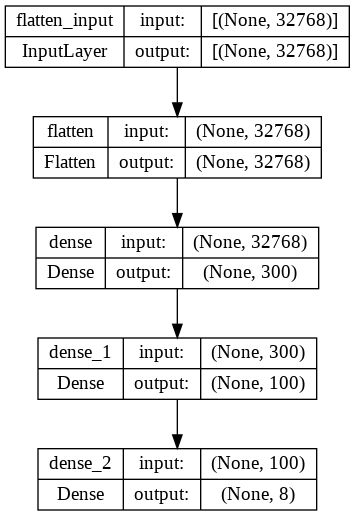

In [ ]:
from keras.utils.vis_utils import plot_model
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

In [ ]:
history = model.fit(x_train, y_train,
          batch_size=128, epochs=30,
          verbose=1,
          validation_data=(x_valid, y_valid))

Epoch 1/30
11/11 [==============================] - 2s 156ms/step - loss: 164748348404793344.0000 - accuracy: 0.1380 - val_loss: 120288968.0000 - val_accuracy: 0.1429
Epoch 2/30
11/11 [==============================] - 1s 133ms/step - loss: 11020925.0000 - accuracy: 0.1451 - val_loss: 1235852.2500 - val_accuracy: 0.1314
Epoch 3/30
11/11 [==============================] - 1s 129ms/step - loss: 735219.0000 - accuracy: 0.1451 - val_loss: 180739.7969 - val_accuracy: 0.1314
Epoch 4/30
11/11 [==============================] - 1s 122ms/step - loss: 43123.5469 - accuracy: 0.1294 - val_loss: 127.4076 - val_accuracy: 0.1371
Epoch 5/30
11/11 [==============================] - 1s 125ms/step - loss: 2.0809 - accuracy: 0.1437 - val_loss: 127.4057 - val_accuracy: 0.1371
Epoch 6/30
11/11 [==============================] - 1s 121ms/step - loss: 2.0789 - accuracy: 0.1437 - val_loss: 127.4038 - val_accuracy: 0.1371
Epoch 7/30
11/11 [==============================] - 1s 120ms/step - loss: 2.0770 - accurac

In [ ]:
y_pred = np.argmax(model.predict(x_valid),axis=-1)
y_pred

11/11 [==============================] - 2s 19ms/step


array([4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,